In [38]:
import random
import re
import string

import contractions

import nltk
from nltk import pos_tag
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from transformers import TFRobertaModel, RobertaTokenizerFast
from keras.utils import plot_model
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint


from tabulate import tabulate
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


In [52]:
path = 'C:\\Users\\tirtn\\Downloads\\archive\\'

In [53]:
data = pd.read_csv(path + 'tweet_emotions.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

In [54]:
data.drop('tweet_id', axis=1, inplace=True)

sentiment = data.pop('sentiment')
data['sentiment'] = sentiment

data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


content   sentiment
0  @tiffanylue i know  i was listenin to bad habi...       empty
1  Layin n bed with a headache  ughhhh...waitin o...     sadness
2                Funeral ceremony...gloomy friday...     sadness
3               wants to hang out with friends SOON!  enthusiasm
4  @dannycastillo We want to trade with someone w...     neutral

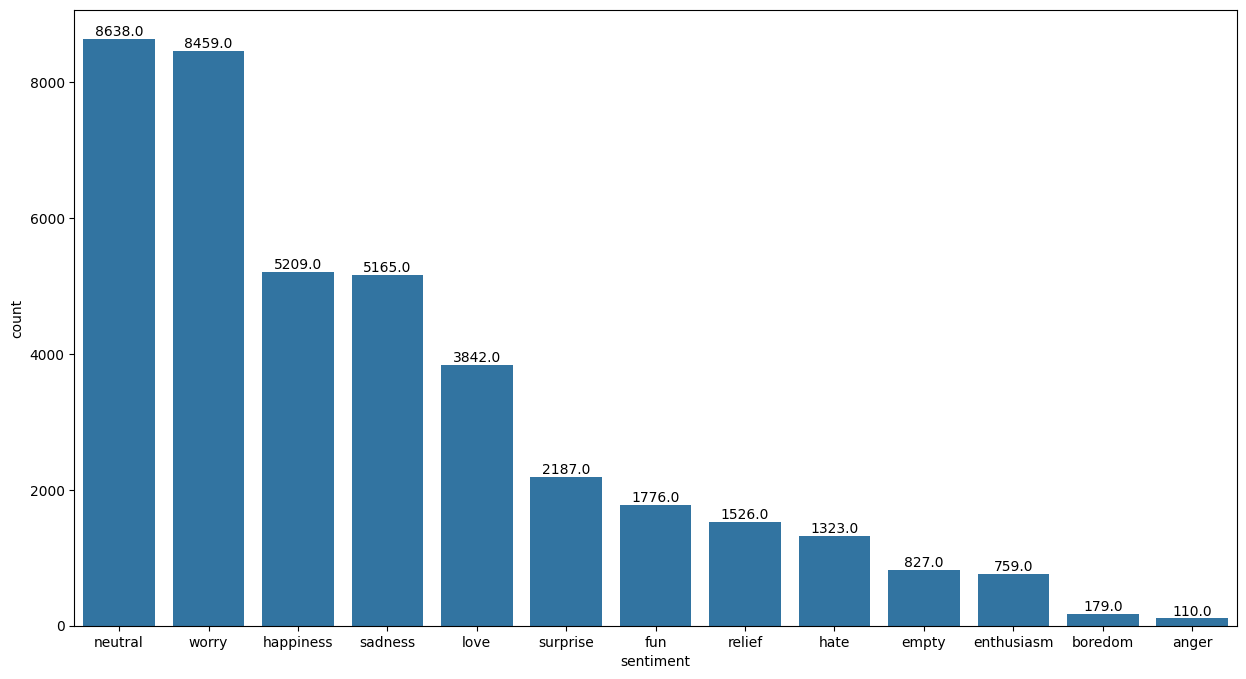

In [55]:
sentiment = data['sentiment'].value_counts()
sentiment_order = list(sentiment.index)

plt.figure(figsize=(15,8))

ax = sns.countplot(x='sentiment', data=data, order=sentiment_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10)
    
plt.show;

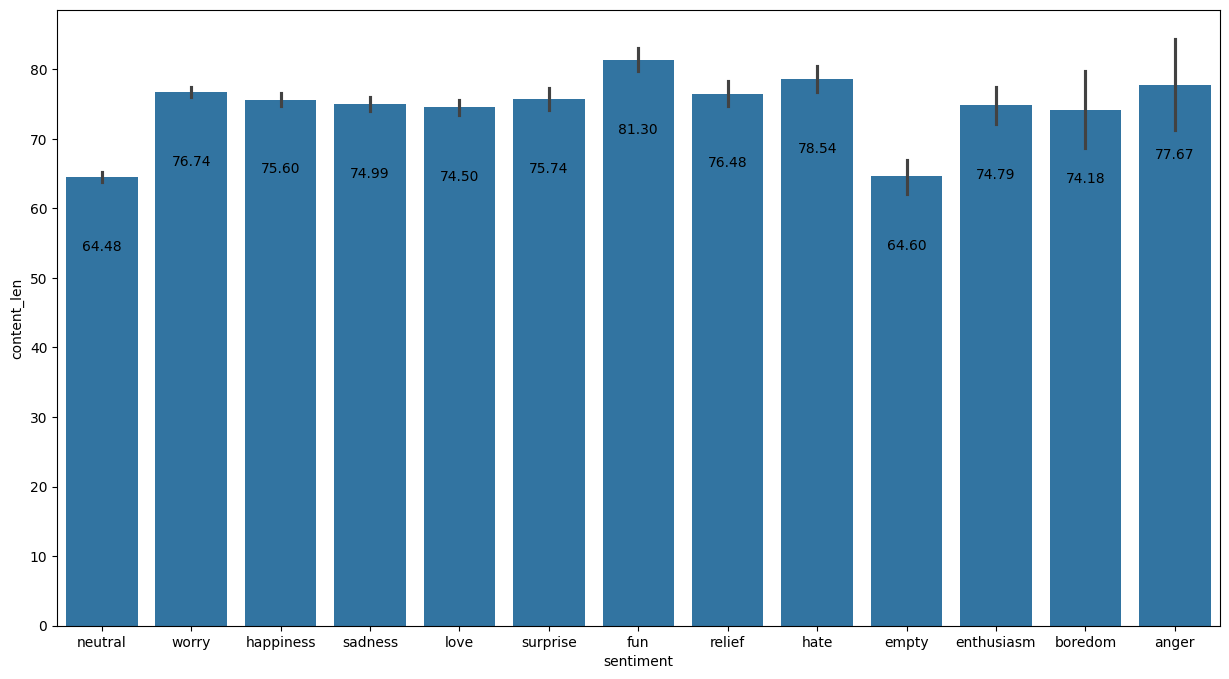

In [58]:
df = data.copy()
df['content_len'] = df['content'].apply(len)

# table
sentiment_grouped_mean_len = df.groupby('sentiment')['content_len'].mean()
sgmlen_transpose = sentiment_grouped_mean_len.to_frame().transpose()

# barplot
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, x='sentiment', y='content_len', estimator=np.mean, order=sentiment_order)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -50), 
                textcoords = 'offset points')
    
plt.show;

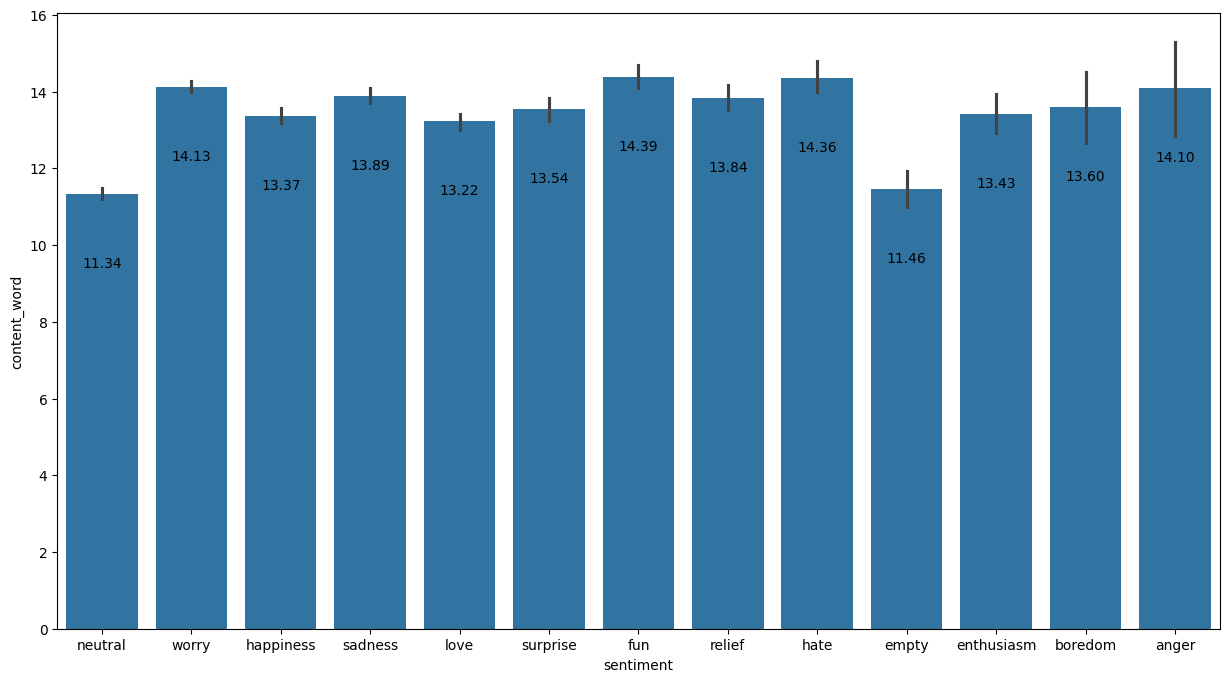

In [59]:
df['content_word'] = data['content'].apply(lambda x: len(x.split()))

# table
sentiment_grouped_mean_word = df.groupby('sentiment')['content_word'].mean()
sgmword_transpose = sentiment_grouped_mean_word.to_frame().transpose()

'''
 print(tabulate(sgmword_transpose.reindex(columns=sentiment_order),
               headers='keys',
               numalign='center',
               stralign='center',
               tablefmt='simple',
               showindex=False))
'''

# barplot
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, x='sentiment', y='content_word', estimator=np.mean, order=sentiment_order)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, -50), 
                textcoords = 'offset points')
    
plt.show;

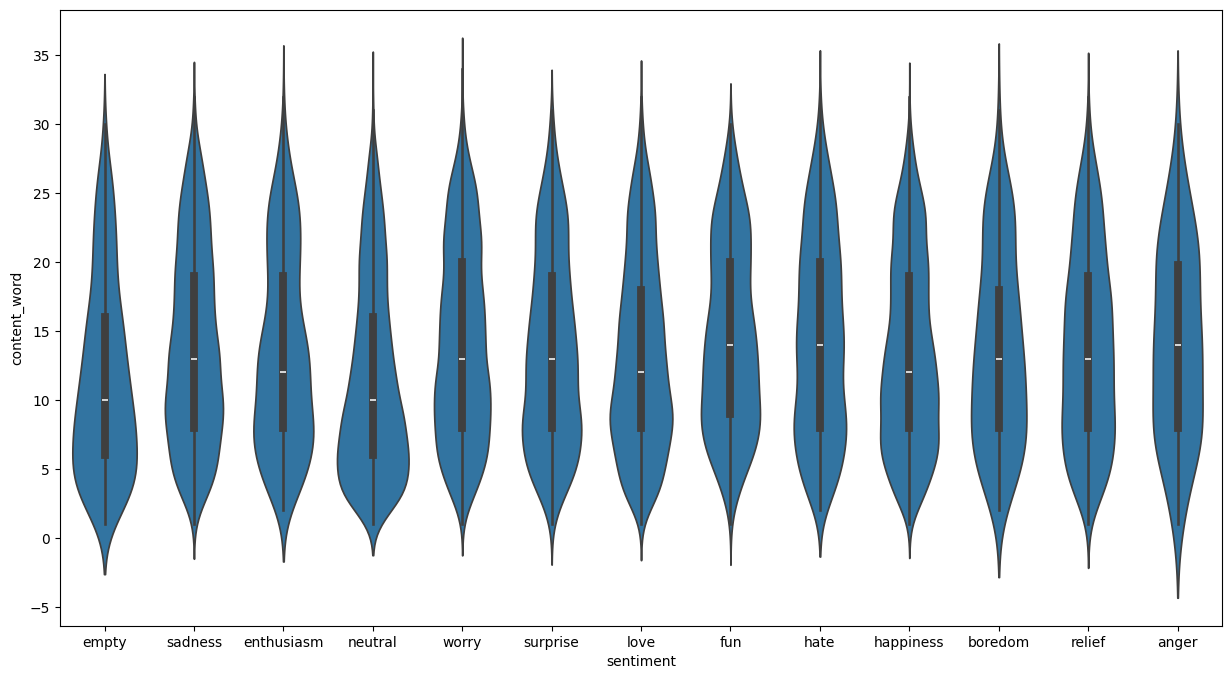

In [60]:
plt.figure(figsize=(15,8))
sns.violinplot(x='sentiment', y = 'content_word', data=df)
plt.show;

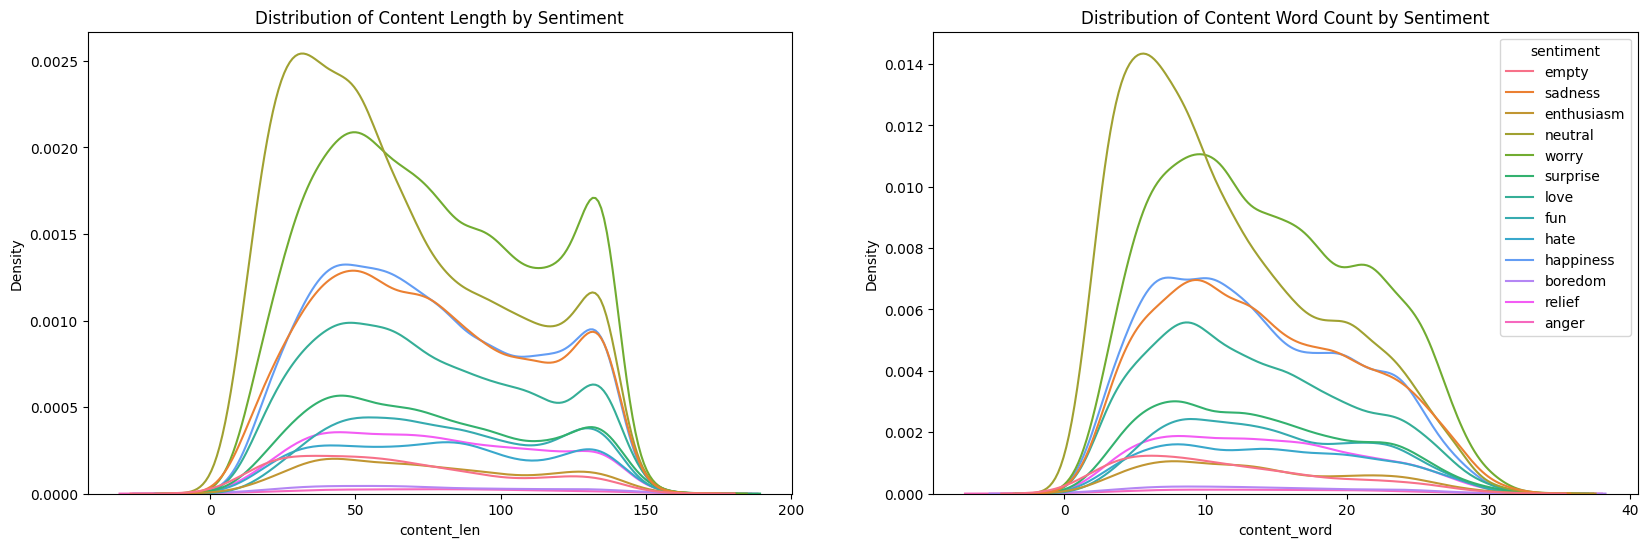

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.kdeplot(x=df['content_len'], hue=df['sentiment'], ax=ax[0], label='content len', legend=False)
ax[0].set_title('Distribution of Content Length by Sentiment')
sns.kdeplot(x=df['content_word'], hue=df['sentiment'], ax=ax[1], label='content word')
ax[1].set_title('Distribution of Content Word Count by Sentiment')

plt.show()

DATA PREPROCESSING 

In [62]:
df_clean = data.copy()

In [50]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tirtn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [63]:
stop_words = set(stopwords.words('english'))

def expand_contractions(text):
    '''
    Function replaces abbreviations with full word versions
    '''
    return contractions.fix(text)

def clean_content(text):

    text = expand_contractions(text)
    # remove twitter handles
    clean_text = re.sub(r'@\w+\s?', '', text)
    
    # convert to lowercase
    clean_text = clean_text.lower()
    
    # remove links http:// or https://
    clean_text = re.sub(r'https?:\/\/\S+', '', clean_text)
    
    # remove links beginning with www. and ending with .com
    clean_text = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', clean_text)
    
    # remove html reference characters
    clean_text = re.sub(r'&[a-z]+;', '', clean_text)
    
    # remove non-letter characters besides spaces "/", ";" "[", "]" "=", "#"
    clean_text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', clean_text)           
    clean_text = clean_text.split()
    
    # remove stop words
    clean_lst = []
    for word in clean_text:
      if word not in stop_words:
        clean_lst.append(word)
    

    lemmatized_words = []
    for word in clean_lst:
      
      # Assign a tag to each part of speech
      tag = pos_tag([word])[0][1][0].upper()
      tag_dict = {'J': wordnet.ADJ,
                  'N': wordnet.NOUN,
                  'V': wordnet.VERB,
                  'R': wordnet.ADV}
      pos = tag_dict.get(tag, wordnet.NOUN)
      
      # lemmatization
      lemmatized_word = WordNetLemmatizer().lemmatize(word, pos)
      
      lemmatized_word = WordNetLemmatizer().lemmatize(word)
      lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

df_clean['content'] = df_clean['content'].apply(lambda x :  clean_content(x))

# delete duplicates
df_clean.drop_duplicates(subset='content', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# delete small sentence
df_clean = df_clean.loc[df_clean['content'].apply(lambda x: len(x) >= 3)]

# splitting into tokens, features of the structure of the text used in Twitter
df_clean['content'] = df_clean['content'].apply(TweetTokenizer().tokenize)

# remove punctuation marks
PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    return [w for w in word_list if w not in PUNCUATION_LIST]
df_clean['content'] = df_clean['content'].apply(remove_punctuation)
df_clean['content'] = df_clean['content'].apply(lambda x: ' '.join(x))


df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 38303 entries, 0 to 38326
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    38303 non-null  object
 1   sentiment  38303 non-null  object
dtypes: object(2)
memory usage: 897.7+ KB


content   sentiment
0  know listenin bad habit earlier started freaki...       empty
1             layin n bed headache ughhhhwaitin call     sadness
2                      funeral ceremonygloomy friday     sadness
3                              want hang friend soon  enthusiasm
4              want trade someone houston ticket one     neutral

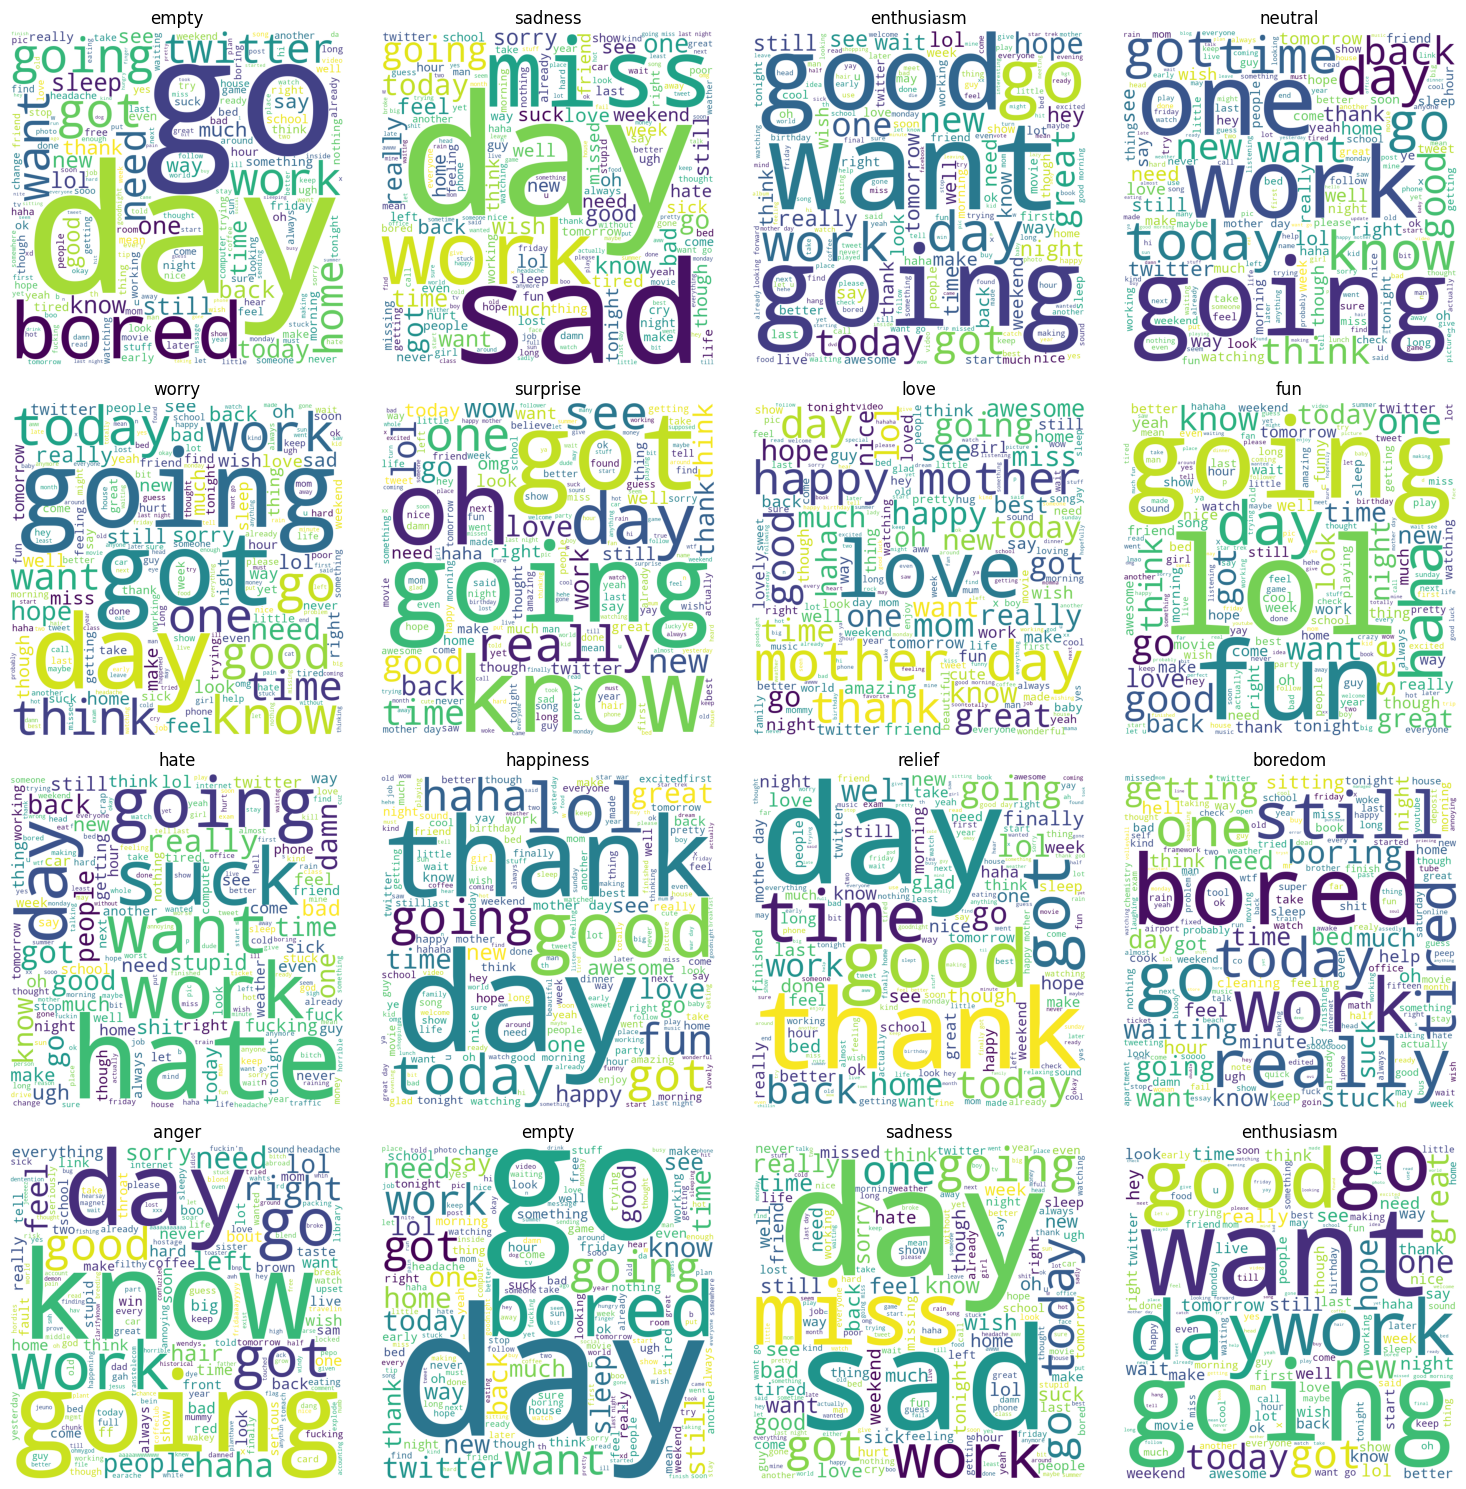

In [64]:
sentiments = df_clean['sentiment'].unique()
sentiments = list(sentiments)
sentiments = list(sentiments) + list(sentiments[:3])

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for ax, sentiment in zip(axes.flatten(), sentiments):
    text = " ".join(df_clean[df_clean['sentiment'] == sentiment]['content'])
    cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    ax.imshow(cloud)
    ax.set_title(sentiment)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [65]:
df_train = df_clean.copy()

In [66]:
def conf_matrix(y, y_pred, labels, title):
    fig, ax =plt.subplots(figsize=(10,10))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":15})
    ax.xaxis.set_ticklabels(labels, fontsize=10) 
    ax.yaxis.set_ticklabels(labels, fontsize=10)
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    plt.show()

In [67]:
def split_data(df):
  train = df.copy()

  x = np.array(train['content'].values)
  y = np.array(train['sentiment'].values)

  # convert categorical to numeric
  encoder = LabelEncoder()
  y = encoder.fit_transform(y)
  labels = np.unique(encoder.inverse_transform(y))

  # split data on train and test
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

  # convert text to vectors with TF-IDF
  tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
  x_train = tf.fit_transform(x_train).toarray()
  x_test = tf.transform(x_test).toarray()

  return x_train, x_test, y_train, y_test, labels

In [69]:
def LogR_train_grid(X, x, Y, y, l):

  params = {'penalty': ['l1', 'l2'],
            'C': [0.001, 0.1, 1],}

  lr = LogisticRegression()

  grid = GridSearchCV(lr, param_grid=params, cv=4)      

  grid.fit(X, Y)

  y_pred = grid.predict(x)
  accuracy = grid.score(x, y)

  return accuracy, grid.best_params_

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy, best_param = LogR_train_grid(X_train, X_test, y_train, y_test, labels)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Best parametrs: ', best_param)


Accuracy: 34.71%
Best parametrs:  {'C': 1, 'penalty': 'l2'}


Accuracy on train: 39.13%
Accuracy on test: 34.71%

Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        35
       empty       0.00      0.00      0.00       151
  enthusiasm       0.00      0.00      0.00       146
         fun       0.22      0.03      0.05       350
   happiness       0.35      0.39      0.37      1002
        hate       0.45      0.14      0.21       259
        love       0.46      0.36      0.40       722
     neutral       0.33      0.57      0.42      1605
      relief       0.45      0.06      0.10       295
     sadness       0.35      0.25      0.29      1007
    surprise       0.28      0.04      0.08       424
       worry       0.34      0.46      0.39      1643

    accuracy                           0.35      7661
   macro avg       0.25      0.18      0.18      7661
weighted avg       0.33      0.35      0.31      7661


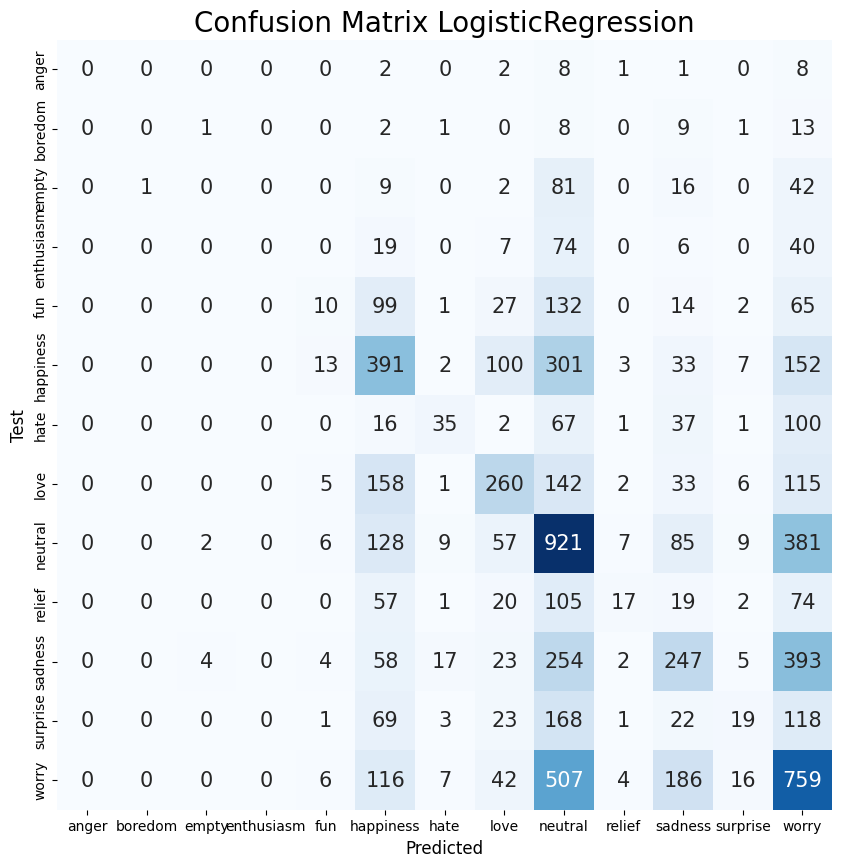

In [70]:
def LogR_train(X, x, Y, y, l):
  
  lr = LogisticRegression()
   
  lr = LogisticRegression(penalty='l2', C=1)
  lr.fit(X, Y)

  y_pred = lr.predict(x)

  accuracy_test = lr.score(x, y)
  accuracy_train = lr.score(X, Y)

  return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy_test, accuracy_train, y, y_pred = LogR_train(X_train, X_test, y_train, y_test, labels)


print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix LogisticRegression')

Accuracy on train: 38.10%
Accuracy on test: 34.83%

Classification Report:

               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        35
       empty       0.00      0.00      0.00       151
  enthusiasm       0.00      0.00      0.00       146
         fun       0.00      0.00      0.00       350
   happiness       0.34      0.39      0.37      1002
        hate       0.53      0.12      0.19       259
        love       0.47      0.35      0.40       722
     neutral       0.32      0.60      0.42      1605
      relief       0.63      0.04      0.08       295
     sadness       0.43      0.16      0.24      1007
    surprise       0.33      0.01      0.01       424
       worry       0.34      0.51      0.41      1643

    accuracy                           0.35      7661
   macro avg       0.26      0.17      0.16      7661
weighted avg       0.35      0.35      0.30      7661


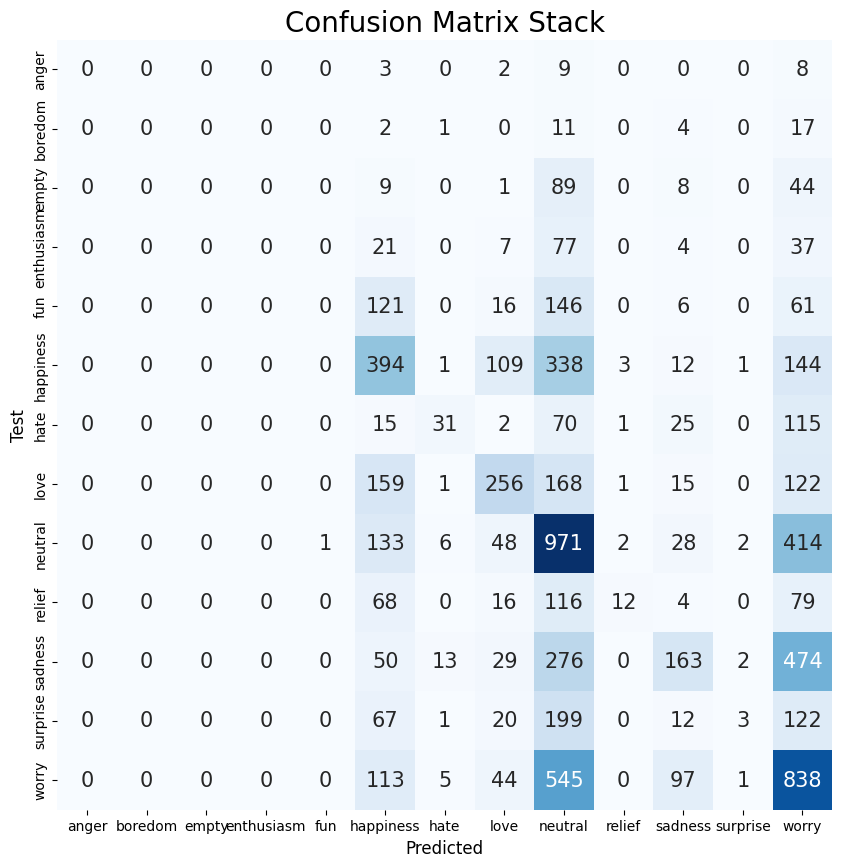

In [71]:
def stacking(X, x, Y, y, l):

    estimators = [
      ('rf', RandomForestClassifier(n_estimators=50, criterion='entropy', random_state=10, max_depth=4, max_features='log2')),
      ('svr', LinearSVC(dual=False, random_state=42))
      ]
    clf_stck = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(penalty='l2', C=1))
    clf_stck.fit(X, Y)

    y_pred = clf_stck.predict(x)

    accuracy_test = clf_stck.score(x, y)
    accuracy_train = clf_stck.score(X, Y)

    return accuracy_test, accuracy_train, y, y_pred

X_train, X_test, y_train, y_test, labels = split_data(df_train)

accuracy_test, accuracy_train, y, y_pred = stacking(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix Stack')

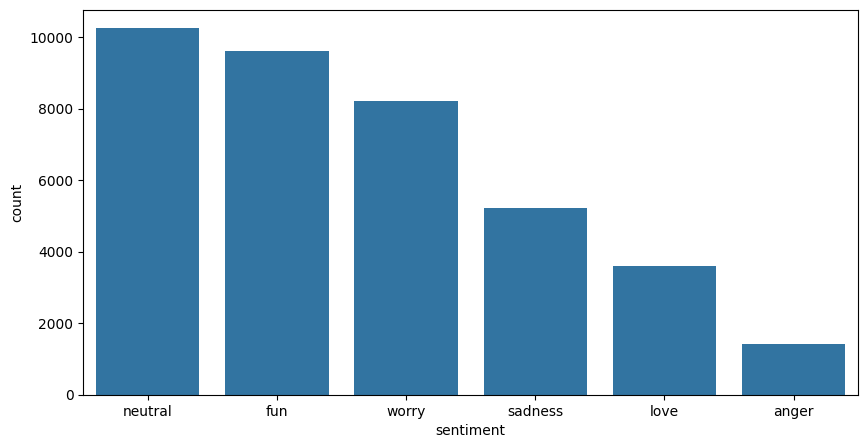

In [72]:
df_reduce = df_train.copy()

df_reduce['sentiment'] = df_reduce['sentiment'].replace(['happiness', 'enthusiasm', 'surprise'], 'fun')
df_reduce['sentiment'] = df_reduce['sentiment'].replace('boredom', 'sadness')
df_reduce['sentiment'] = df_reduce['sentiment'].replace('hate', 'anger')
df_reduce['sentiment'] = df_reduce['sentiment'].replace(['relief', 'empty'], 'neutral')

plt.figure(figsize=(10,5))
ax = sns.countplot(x='sentiment', data=df_reduce, order=df_reduce['sentiment'].value_counts().index)

plt.show();

Accuracy on train: 45.18%
Accuracy on test: 40.60%

Classification Report:

               precision    recall  f1-score   support

       anger       0.52      0.11      0.19       281
         fun       0.43      0.49      0.46      1922
        love       0.52      0.26      0.35       722
     neutral       0.40      0.59      0.47      2051
     sadness       0.42      0.17      0.24      1042
       worry       0.36      0.35      0.35      1643

    accuracy                           0.41      7661
   macro avg       0.44      0.33      0.34      7661
weighted avg       0.42      0.41      0.39      7661


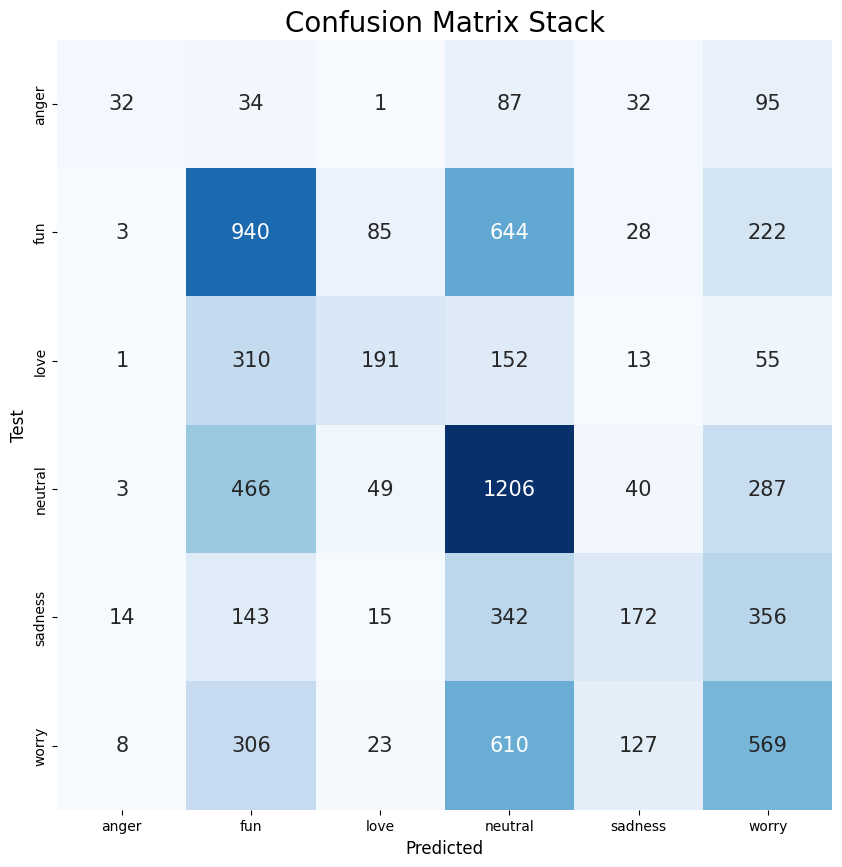

In [73]:
X_train, X_test, y_train, y_test, labels = split_data(df_reduce)

accuracy_test, accuracy_train, y, y_pred = stacking(X_train, X_test, y_train, y_test, labels)

print('Accuracy on train: {:.2f}%'.format(accuracy_train*100))
print('Accuracy on test: {:.2f}%'.format(accuracy_test*100))
print('\nClassification Report:\n\n',classification_report(y , y_pred, target_names=[str(l) for l in labels]))
conf_matrix(y, y_pred, labels, 'Confusion Matrix Stack')

In [74]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

def resize(train_df, test_df, method):

    X = train_df.drop('sentiment', axis=1)
    y = train_df['sentiment'] 

    X_traine_res, y_train_res = method.fit_resample(X, y)

    df_resampled = pd.concat([X_traine_res, y_train_res], axis=1)
    df_total = pd.concat([df_resampled, test_df], axis=0)
    df_total.reset_index(drop=True, inplace=True)


    x_train = np.array(X_traine_res['content'].values)
    x_test = np.array(test_df['content'].values)
    y_train = np.array(y_train_res)
    y_test = np.array(test_df['sentiment'].values)

    # convert categorical to numeric
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.fit_transform(y_test)
    labels = np.unique(encoder.inverse_transform(y_train))

    # convert text to vectors with TF-IDF
    tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
    X_train = tf.fit_transform(x_train).toarray()
    X_test = tf.transform(x_test).toarray()
    
    
    return X_train, X_test, y_train, y_test, df_total, labels

LogisticRegression after over sampling:

Accuracy train: 48.13%
Accuracy on test: 34.03%

Classification Report:

               precision    recall  f1-score   support

       anger       0.11      0.36      0.17       286
         fun       0.45      0.33      0.38      1973
        love       0.33      0.53      0.41       675
     neutral       0.42      0.37      0.39      2063
     sadness       0.27      0.32      0.29      1017
       worry       0.34      0.25      0.29      1647

    accuracy                           0.34      7661
   macro avg       0.32      0.36      0.32      7661
weighted avg       0.37      0.34      0.35      7661


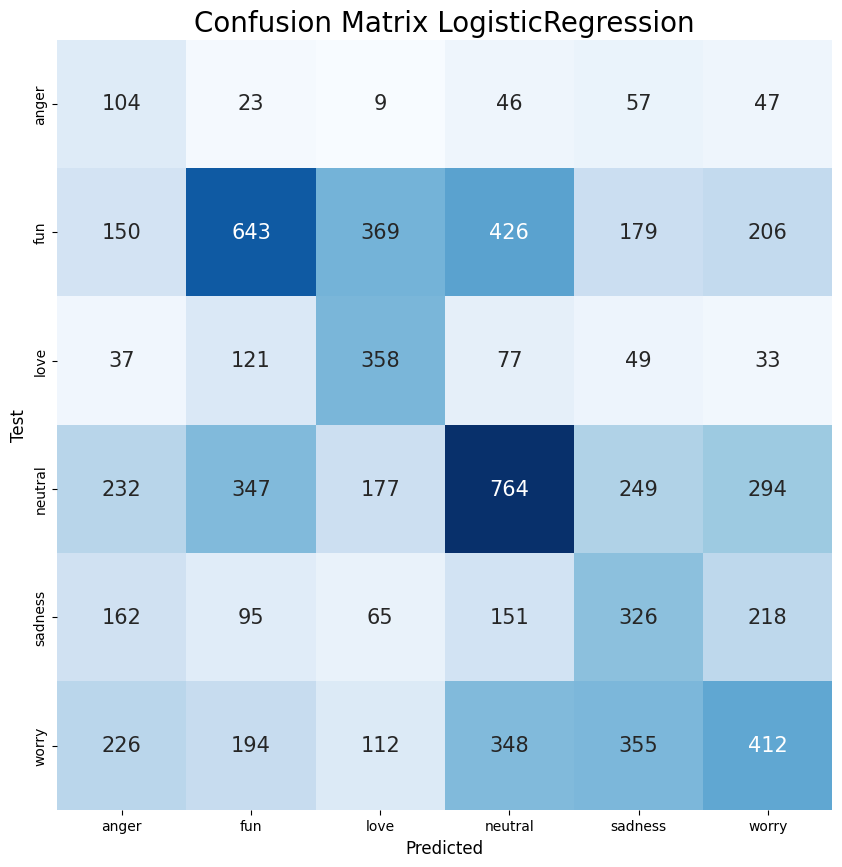

In [75]:
train_df, test_df = train_test_split(df_reduce, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, df_total, labels = resize(train_df, test_df, ros)

acc_test_LR_reduce, acc_train_LR_reduce, y_LR_reduce, y_pred_LR_reduce = LogR_train(X_train, X_test, y_train, y_test, labels)

print('LogisticRegression after over sampling:\n')
print('Accuracy train: {:.2f}%'.format(acc_train_LR_reduce*100))
print('Accuracy on test: {:.2f}%'.format(acc_test_LR_reduce*100))
print('\nClassification Report:\n\n',classification_report(y_LR_reduce, y_pred_LR_reduce, target_names=[str(l) for l in labels]))
conf_matrix(y_LR_reduce, y_pred_LR_reduce, labels, 'Confusion Matrix LogisticRegression')

In [76]:
data_emotion = pd.read_csv('C:\\Users\\tirtn\\Downloads\\archive\\data_emotion.csv')
data_emotion.info()
data_emotion['sentiment'] = data_emotion['sentiment'].replace('surprise', 'fun')
data_emotion['sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


sentiment
fun        7480
sadness    5797
anger      2709
worry      2373
love       1641
Name: count, dtype: int64

In [77]:
train_df, test_df = train_test_split(df_reduce, test_size=0.2, random_state=42)
train_df = pd.concat([train_df, data_emotion], axis=0)
train_df.reset_index(drop=True, inplace=True)

In [78]:
def split_df(train_df, test_df):

  x_train = np.array(train_df['content'].values)
  x_test = np.array(test_df['content'].values)
  y_train = np.array(train_df['sentiment'].values)
  y_test = np.array(test_df['sentiment'].values)

  # convert categorical to numeric
  encoder = LabelEncoder()
  y_train = encoder.fit_transform(y_train)
  y_test = encoder.fit_transform(y_test)
  labels = np.unique(encoder.inverse_transform(y_train))

  # convert text to vectors with TF-IDF
  tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
  X_train = tf.fit_transform(x_train).toarray()
  X_test = tf.transform(x_test).toarray()

  return X_train, X_test, y_train, y_test, labels

LogisticRegression after adding new data:

Accuracy train: 48.80%
Accuracy on test: 39.71%

Classification Report:

               precision    recall  f1-score   support

       anger       0.35      0.12      0.17       286
         fun       0.42      0.45      0.44      1973
        love       0.52      0.32      0.40       675
     neutral       0.40      0.56      0.47      2063
     sadness       0.33      0.23      0.27      1017
       worry       0.36      0.30      0.33      1647

    accuracy                           0.40      7661
   macro avg       0.40      0.33      0.35      7661
weighted avg       0.40      0.40      0.39      7661


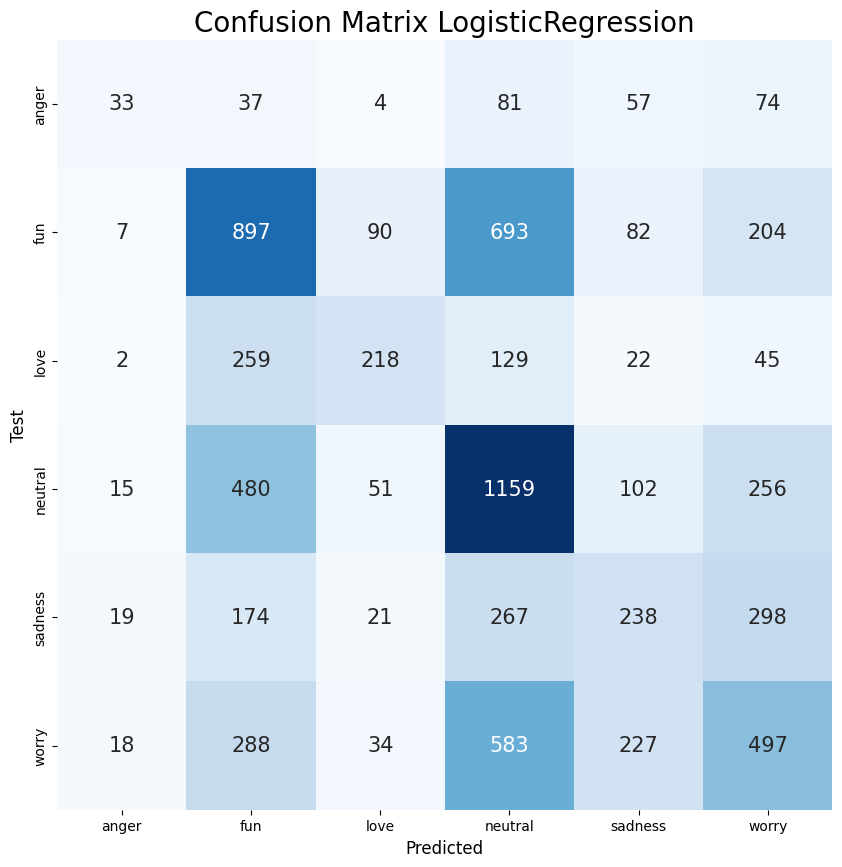

In [79]:
X_train_new, X_test_new, y_train_new, y_test_new, labels_new = split_df(train_df, test_df)

acc_test_LR_reduce, acc_train_LR_reduce, y_LR_reduce, y_pred_LR_reduce = LogR_train(X_train_new, X_test_new, y_train_new, y_test_new, labels_new)

print('LogisticRegression after adding new data:\n')
print('Accuracy train: {:.2f}%'.format(acc_train_LR_reduce*100))
print('Accuracy on test: {:.2f}%'.format(acc_test_LR_reduce*100))
print('\nClassification Report:\n\n',classification_report(y_LR_reduce, y_pred_LR_reduce, target_names=[str(l) for l in labels_new]))
conf_matrix(y_LR_reduce, y_pred_LR_reduce, labels_new, 'Confusion Matrix LogisticRegression')

RoBERTa Modelling

In [80]:
tf.config.list_physical_devices('GPU')

[]

In [81]:
df_dl = df_reduce.copy()
df_dl.shape

(38303, 2)

In [82]:
train_df, test_df = train_test_split(df_dl, test_size=0.35, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 24896; Test: 13407


In [83]:
X_train = train_df['content'].values
y_train = train_df['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 24896; X_test: 10055; X_valid: 3352
y_train: 24896; y_test: 10055; y_valid: 3352


In [84]:
# over sample train_df
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(train_df['content']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['content', 'sentiment'])
train_os['sentiment'].value_counts()

sentiment
neutral    6689
worry      6689
love       6689
fun        6689
anger      6689
sadness    6689
Name: count, dtype: int64

In [85]:
X_train = train_os['content'].values
y_train = train_os['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X = test_df['content'].values
y = test_df['sentiment'].values

X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 40134; X_test: 9384; X_valid: 4023
y_train: 40134; y_test: 9384; y_valid: 4023


In [86]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [87]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

In [88]:
is_train=True

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from transformers import TFRobertaModel, RobertaTokenizerFast
from keras.layers import Dense, Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import ModelCheckpoint

# Check for GPU availability
device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'

path = 'C:\\Users\\tirtn\\Downloads\\archive\\'
train_df = pd.read_csv(path + 'train.txt', sep=';', names=['content', 'sentiment'], header=0)
test_df = pd.read_csv(path + 'test.txt', sep=';', names=['content', 'sentiment'], header=0)
valid_df = pd.read_csv(path + 'val.txt', sep=';', names=['content', 'sentiment'], header=0)
df_train = pd.concat([train_df, test_df, valid_df], axis=0)

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_train['content'], df_train['sentiment'], test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Oversample the minority classes using RandomOverSampler
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns=['content', 'sentiment'])

# Encode the labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_valid_encoded = encoder.transform(np.array(y_valid).reshape(-1, 1))
y_test_encoded = encoder.transform(np.array(y_test).reshape(-1, 1))

# Tokenize the input data
tokenizer = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')
MAX_LEN = 128

class EmotionsDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, tokenizer, max_len, batch_size):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.batch_size = batch_size

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        encodings = self.tokenizer(batch_data.tolist(), truncation=True, padding='max_length', max_length=self.max_len, return_tensors='tf')
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        return {'input_ids': input_ids, 'attention_mask': attention_mask}, tf.convert_to_tensor(batch_labels, dtype=tf.int32)

batch_size = 32

train_dataset = EmotionsDataset(train_os['content'].values, y_train_encoded, tokenizer, MAX_LEN, batch_size)
valid_dataset = EmotionsDataset(X_valid.values, y_valid_encoded, tokenizer, MAX_LEN, batch_size)
test_dataset = EmotionsDataset(X_test.values, y_test_encoded, tokenizer, MAX_LEN, batch_size)

roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

class EmotionClassifier(Model):
    def __init__(self, bert_model, num_classes):
        super(EmotionClassifier, self).__init__()
        self.bert_model = bert_model
        self.dropout = Dropout(0.2)
        self.fc = Dense(num_classes)

    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, training=training)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.fc(pooled_output)
        return logits

num_classes = len(encoder.classes_)
lr = 2e-5
num_epochs = 1

input_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
inputs = {'input_ids': input_layer, 'attention_mask': mask_layer}

classifier = EmotionClassifier(roberta_model, num_classes)
outputs = classifier(inputs)
model = Model(inputs, outputs)

optimizer = Adam(learning_rate=lr)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metric])

# Train the model
history = model.fit(train_dataset, epochs=num_epochs, validation_data=valid_dataset)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Optionally, save the model after training
model.save_weights('classifier_params.h5')

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


 250/1008 [======>.......................] - ETA: 2:15:31 - loss: 0.8552 - sparse_categorical_accuracy: 0.6867